In [1]:
from typing import Any, List, Optional, Tuple, Union
import numpy as np
from magic_pen.config import DEVICE
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform
from segment_any_change.embedding import (
    compute_mask_embedding,
    get_img_embedding_normed,
)
from segment_any_change.masks.mask_items import (
    FilteringType,
    ImgType,
    ListProposal,
)
from segment_any_change.matching import (
    BitemporalMatching,
    neg_cosine_sim,
)
import torch
import torchvision
from torch.nn import functional as F
import kornia as K
from segment_any_change.model import BiSam
from segment_any_change.sa_dev_v0.predictor import SamPredictor
from torch.utils.data import DataLoader
from segment_any_change.utils import *
import matplotlib.pyplot as plt
from magic_pen.config import project_path
from magic_pen.utils_io import make_path
import os
from segment_any_change.inference import load_default_sam_params

import logging
import pickle

# TO DO : define globally
logging.basicConfig(format="%(asctime)s - %(levelname)s ::  %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
params = load_default_sam_params()

In [8]:
ls /var/data/usr/mdizier/stylo_magique/lightning_logs/predictions-vit_h/

predictions.pt


In [9]:
path= "/var/data/usr/mdizier/stylo_magique/lightning_logs/predictions-vit_h/predictions.pt"
res = torch.load(path)

In [10]:
type(res)

list

In [11]:
len(res)

1

In [12]:
res[0].keys()

dict_keys(['metrics', 'pred', 'batch_idx'])

In [20]:
res[0]["batch_idx"]

0

In [15]:
res[0]["pred"]["masks"].shape

torch.Size([2, 54, 1024, 1024])

In [19]:
plt.imshow(to_numpy(res[0]["batch"]["label"][0, ...], transpose=False))

KeyError: 'batch'

In [21]:
pred = torch.sum(res[0]["pred"]["masks"][0, ...], axis=0).unsqueeze(0).repeat(3, 1, 1).to(torch.uint8)

In [24]:
def shift_range_values(arr, new_bounds=[0, 1]): 
    old_range = (torch.max(arr) - torch.min(arr))  
    new_range = (new_bounds[1] - new_bounds[0])  
    shit_arr = (((arr - torch.min(arr)) * new_range) / old_range) + new_bounds[0]
    return shit_arr

pred_ = shift_range_values(pred)

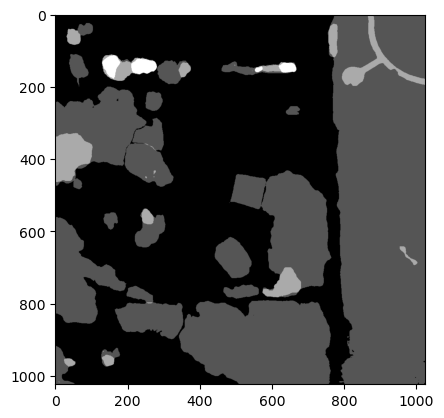

In [25]:
plt.imshow(to_numpy(pred_))

2024-06-03 15:42:37,164 - WARNING ::  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


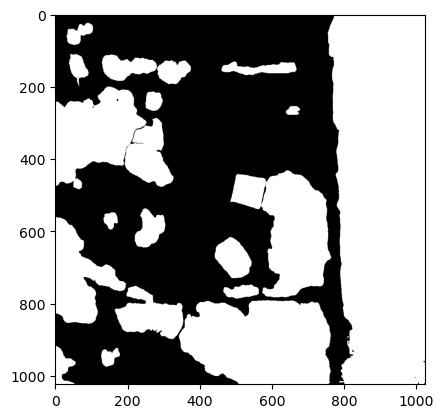

In [22]:
plt.imshow(to_numpy(pred))

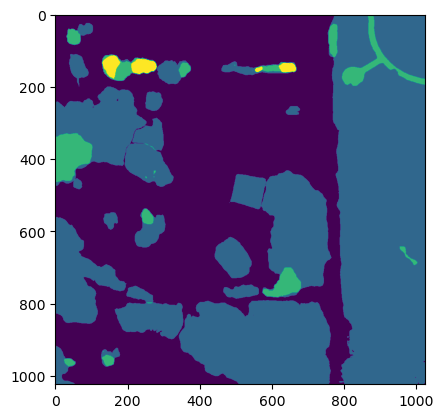

In [18]:
plt.imshow(to_numpy(torch.sum(res[0]["pred"]["masks"][0, ...], dim=0), transpose=False))

In [9]:
with open(make_path(f"tmp/generator_return_{params.model_type}.pkl", project_path), "rb") as fp:
    res = pickle.load(fp)

2

In [10]:
def show(imgs):
    if not isinstance(imgs, list) and not imgs.ndim > 2:
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 10))
    for i, img in enumerate(imgs):
        img = img.to(torch.float).detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [11]:
for m in res:
    print(m["img_type"])
    print(m["masks"].shape)

ImgType.A
(22, 1024, 1024)
ImgType.B
(28, 1024, 1024)


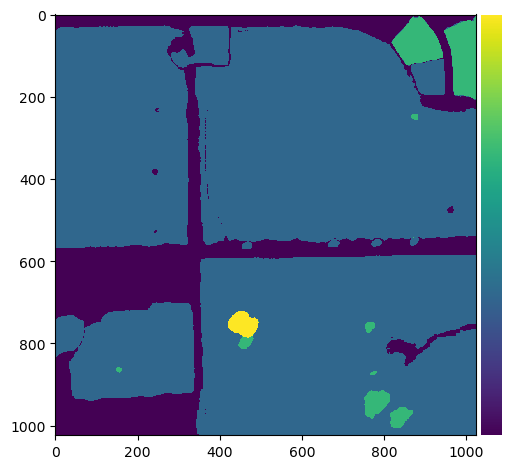

In [12]:
show_img(np.sum(res[0]["masks"], axis=0))

In [22]:
res[0].keys()

dict_keys(['masks', 'predicted_iou', 'point_coords', 'img_type'])

In [23]:
res[0]["masks"].shape

(22, 1024, 1024)